# GLOBAL TERRORISM DATABASE (GTD)

GTD es una base de datos que incluye **más de 200.000 ataques terroristas** registrados desde 1970, creada por el <a href="https://www.start.umd.edu/gtd/about/" target="_blank">Consorcio Nacional para el Estudio y Respuesta al Terrorismo (START)</a>.


En el <a href="https://www.start.umd.edu/gtd/downloads/Codebook.pdf" target="_blank">Glosario de Campos</a> es posible consultar qué valores puede tomar cada variable.

### **AUTOR: JAIME BLANCO LINARES**

# Question
##  ¿Qué organización terrorista ha sido la responsable del ataque?

Queremos entrenar un modelo que, dado un ataque terrorista, determine qué organización terrorista está detrás de dicho ataque.

# 1. Prepare Problem

## a) Load libraries: import libraries and function definitions

In [217]:
#Spark en Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [218]:
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import sklearn
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import category_encoders

In [219]:
# Enable Arrow-based spark configuration
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [220]:
# Función que devuelve las dimensiones de un dataframe
def shape(sp_df):
    return sp_df.count(), len(sp_df.columns)

In [221]:
# Función que devuelve un dataframe con las columnas ordenadas alfabéticamente
def sort_columns(sp_df):
    cols_sorted = sorted(sp_df.columns)
    return sp_df.select(cols_sorted)

## b) Load dataset: load csv, subiendolo a Databrick

In [222]:
# OPCIÓN COLAB
df = spark.read.\
      option('inferSchema', 'true').\
      option('header', 'true').\
      option('sep',',').\
      option('encoding', 'ISO-8859-1').\
      csv('./glob_terr.csv')

shape(df)

(185163, 135)

In [223]:
# # OPCIÓN DATABRICKS
# #leemos el csv y lo depositamos en memoria
# df = spark.read.\
#       option('inferSchema', 'true').\
#       option('header', 'true').\
#       option('sep',',').\
#       option('encoding', 'ISO-8859-1').\
#       csv('/FileStore/tables/glob_terr.csv')

# shape(df)

# 2. Summarize Data

## a) Descriptive statistics

### Variables cuantitativas

In [225]:
df.printSchema()

root
 |-- eventid: long (nullable = true)
 |-- iyear: integer (nullable = true)
 |-- imonth: integer (nullable = true)
 |-- iday: integer (nullable = true)
 |-- approxdate: string (nullable = true)
 |-- extended: integer (nullable = true)
 |-- resolution: string (nullable = true)
 |-- country: integer (nullable = true)
 |-- country_txt: string (nullable = true)
 |-- region: integer (nullable = true)
 |-- region_txt: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- specificity: double (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- crit1: string (nullable = true)
 |-- crit2: string (nullable = true)
 |-- crit3: string (nullable = true)
 |-- doubtterr: string (nullable = true)
 |-- alternative: string (nullable = true)
 |-- alternative_txt: string (nullable 

Analicemos la existencia de multicolinealidad.
<br>Aunque el inferschema haya interpretado algunas variables cuantitativas como tipo string tambien, obtenemos cuáles son del Glosario:

In [226]:
numericas_puras = 'iyear imonth iday latitude longitude nperps nperpcap nkill nkillus nkillter nwound nwoundus nwoundte propvalue nhostkid nhostkidus nhours ndays ransomamt ransomamtus ransompaid ransompaidus nreleased'\
                  .split(' ')

df_temp = df[numericas_puras]
shape(df_temp)

(185163, 23)

In [227]:
# Casteamos columnas no reconocidas como numéricas, pero que según el glosario sí lo son
cols_num = [c for c, t in df_temp.dtypes if t !='string']
cols_no_num = [item[0] for item in df_temp.dtypes if item[1].startswith('string')]
print(f'Antes - Columnas numéricas: {len(cols_num)}, no numéricas: {len(cols_no_num)}')

for c in cols_no_num:
  df_temp = df_temp.withColumn(c, df[c].cast(T.IntegerType()))

cols_num = [c for c, t in df_temp.dtypes if t !='string']
cols_no_num = [item[0] for item in df_temp.dtypes if item[1].startswith('string')]
print(f'Antes - Columnas numéricas: {len(cols_num)}, no numéricas: {len(cols_no_num)}')

Antes - Columnas numéricas: 5, no numéricas: 18
Antes - Columnas numéricas: 23, no numéricas: 0


In [228]:
# Visualizamos distribución y relación entre variables numéricas
# t = time.time()
# # Tarda bastante en completarse
# sns.pairplot(df_temp.toPandas())
# print(f'Tiempo: {time.time() - t} s.')

Con el fin de detectar posible existencia de multicolinealidad entre las variables numéricas, visualizamos los coeficientes de correlación de Spearman, ya que no vamos a hacer ninguna suposición acerca de la normalidad de las distribuciones de nuestros datos.

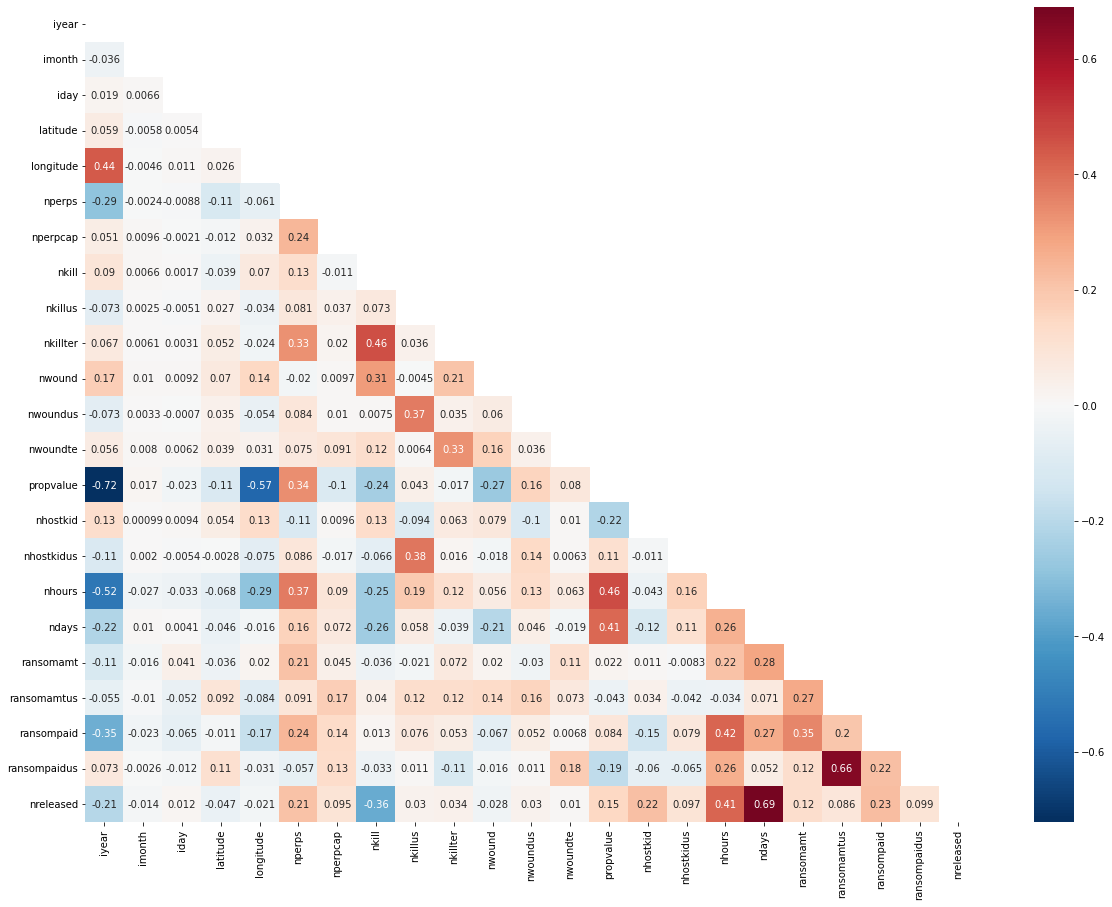

In [229]:
# Generamos matriz de correlación en Pandas
corr = df_temp.toPandas().corr(method='spearman')

# Máscara para que se muestre solo un triángulo y mejore la visualización
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotea la matriz de correlación
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0)

No se aprecia nada llamativo más allá de las siguientes ideas:
- Conforme avanza el año, algunos valores decrecen. Quizá se dejaron de informar ciertos campos.
- Existe una correlación visible entre el año y la coordenada longitud del ataque.
- Fuerte correlación entre ndays (nº días de secuestro, si lo hubo) y nreleased (nº de rehenes, si hubo, que consiguieron liberarse), lo cual parece razonable.
- Correlación entre propvalue (valor de la propiedad contra la que se atentó) y nhours (duración en horas del secuestro). No sabemos si implica causalidad o no.

**Análisis preliminar de outliers:**

In [230]:
# df_temp_bx = df_temp[list(set(numericas_puras)-set(['latitude','longitude']))]
df_temp_bx = df_temp[numericas_puras]
df_temp_bx_pd = df_temp_bx.toPandas()
df_temp_bx_pd.shape

(185163, 23)

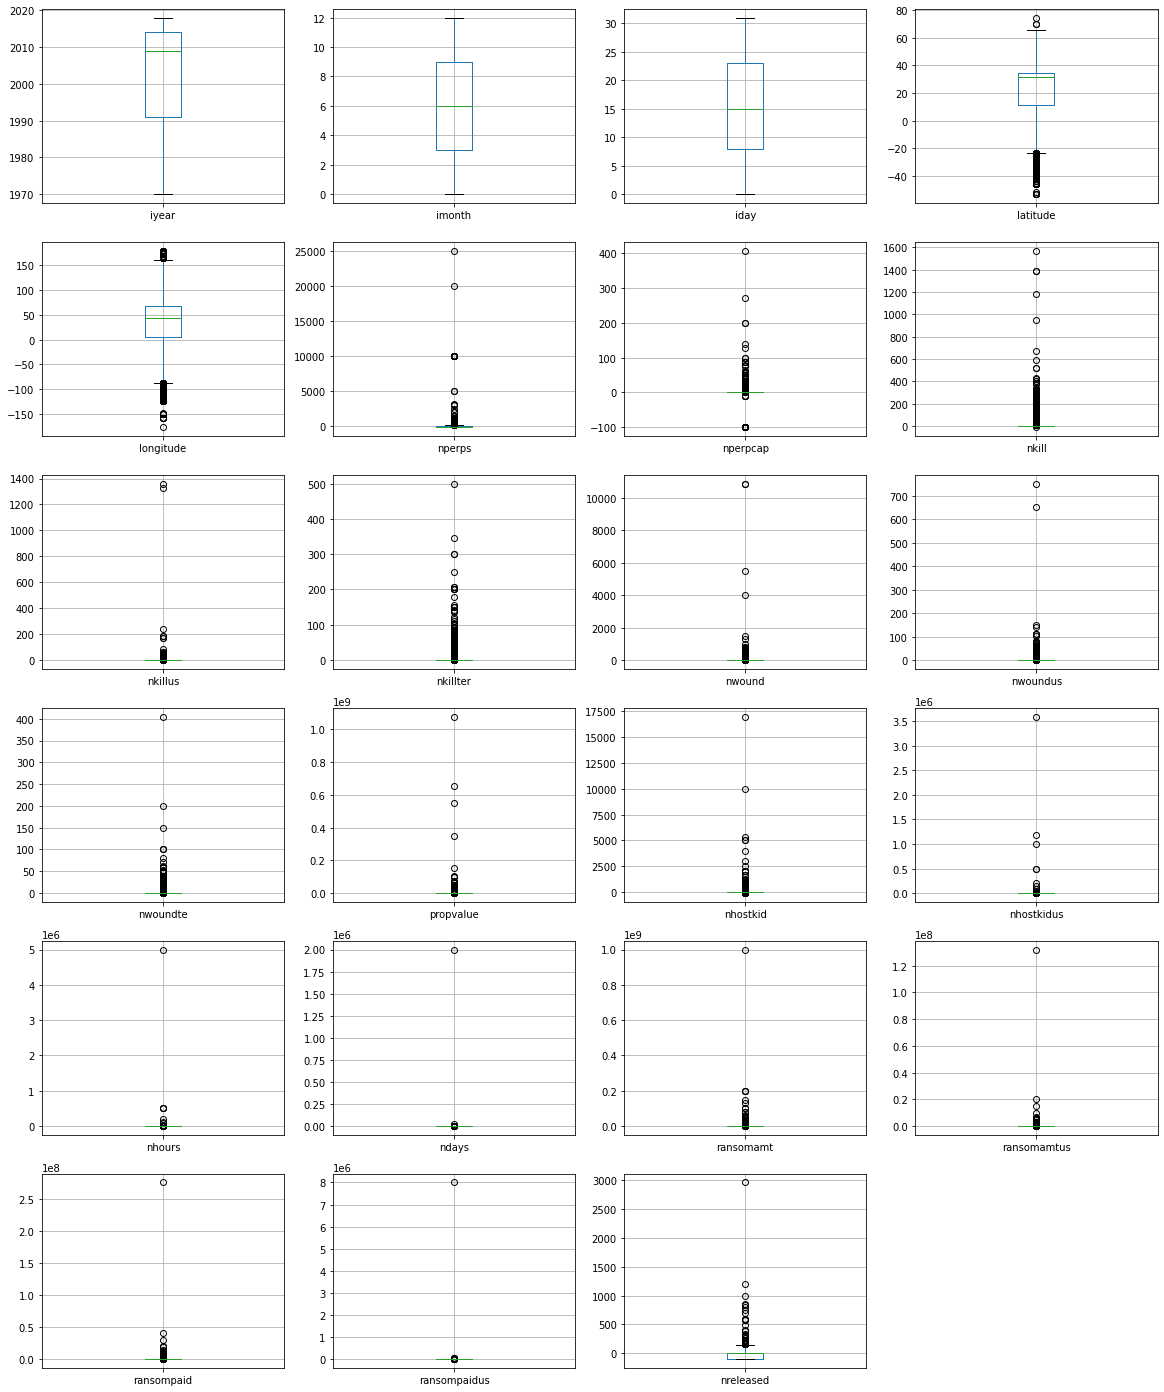

In [231]:
# Solo en columnas numéricas
dii = {}
fig = plt.figure(figsize=(20,25))
cols_box = df_temp_bx_pd.columns
# Recorremos la matriz de visualización, ploteando
for i in range (len(cols_box)):
  dii[i] =fig.add_subplot(6,4,i+1)
  df_temp_bx_pd.boxplot(column=cols_box[i])

plt.show()

Se observa la presencia de valores atípicos en algunas variables. Más adelante, en el apartado de Data Cleaning se decidirá cómo tratarlos.

### Variables cualitativas

Vemos que cada columna tipo string, suele tener otra columna con su categorización numérica asociada (aunque el inferschema haya interpretado estas últimas como tipo string tambien, solo habrá que castearlas en el momento oportuno). Creamos la lista 'col_txt_drop' para almacenar las variables que son puramente de tipo texto y descartarlas en el presente apartado de análisis estadístico de las variables cuantitativas y, más adelante, en la parte de limpieza, las eliminaremos definitivamente.
Se descartarán dichos campos por los siguientes motivos:
- **provstate, city, location**: Son de tipo texto y ya disponemos de otros campos con la codificación numérica correspondiente.
- **summary, motive, propcomment, addnotes, ransomnote, scite1-3, dbsource, related, weapdetail**: Mucha información descriptiva en bruto de la cual, de momento, no vamos a extraer información para el modelo.
- **corp1, target1, corp2, target2, corp3, target3**: Atienden a los nombres de organizaciones/personas específicas a las que van dirigidas el ataque y ya tienen asociada la codificación según su tipología en los campos targtype1-3 targsubtype1-3.
- **divert, kidhijcountry**: Expresan fenómenos realmente atípicos y por tanto hay un elevadísimo % de nulos.
- **approxdate, resolution**: Hay otros campos numéricos referentes a fechas mucho más fiables que estos, ya que informan de la fecha con un literal y tienen un elevadísimo % de nulos.

In [232]:
# Primero, las que contienen 'txt' en su nombre:
col_txt_drop = [col for col in df.columns if col.find('txt') != -1]
# Luego, el resto de las que no nos interesan
col_txt_drop += ['provstate', 'city', 'location', 'summary', 'corp1', 'target1', 'corp2', 'target2', 'corp3', 'target3', 'motive', 'weapdetail', 'propcomment', 'divert',
            'kidhijcountry', 'ransomnote', 'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'related', 'approxdate', 'resolution']

In [233]:
# # df.summary() apenas aporta información relevante, ya que gran parte de las variables son categóricas.
# # Por este motivo, utilizamos summarize de Databricks para ver el profiling
# dbutils.data.summarize(df.drop(*col_txt_drop))

## b) Data visualizations
Utilizamos display() de Databricks para mostrar algunas visualizaciones muy interesantes. Algunos de los dataframes agregados que se definen en este apartado servirán para la limpieza de datos más adelante, como *gterr*.

### 1) Víctimas y heridos e incidentes por año

In [234]:
anyo = df.groupBy('iyear').agg(F.count('gname').alias('n_atentados'),
                                F.sum('nkill').alias('n_victimas'),
                                F.sum('nwound').alias('n_heridos'))\
                            .sort(F.col('iyear'))

In [235]:
display(anyo)

DataFrame[iyear: int, n_atentados: bigint, n_victimas: double, n_heridos: double]

<center><img src="images/2b) 1.PNG"/></center>

### 2) Víctimas y heridos atribuidos a cada grupo terrorista (Top 30)

In [236]:
gterr = df.groupBy('gname').agg(F.count('gname').alias('n_atentados'),
                                F.sum('nkill').alias('n_victimas'),
                                F.sum('nwound').alias('n_heridos'))\
                            .sort(F.col('n_victimas').desc())

In [237]:
display(gterr[gterr['gname']!='Unknown'].limit(70))

DataFrame[gname: string, n_atentados: bigint, n_victimas: double, n_heridos: double]

<center><img src="images/2b) 2.PNG"/></center>

### 3) Víctimas por año atribuidas a cada grupo terrorista (Top 30)

In [238]:
gterr_anyo = df.groupBy('gname', 'iyear').agg(F.count('gname').alias('n_atentados'),
                                F.sum('nkill').alias('n_victimas'),
                                F.sum('nwound').alias('n_heridos'))\
                                .sort(F.col('gname').desc(), F.col('iyear').desc())

In [239]:
# Creamos el acumulado de víctimas por año mediante función Window
windowval = (Window.partitionBy('gname').orderBy('iyear')
             .rangeBetween(Window.unboundedPreceding, 0))
victim_acum = gterr_anyo.withColumn('acum_vict', F.sum('n_victimas').over(windowval))

In [240]:
lista = ["Taliban","Islamic State of Iraq and the Levant (ISIL)", "Boko Haram", "Hezbollah", "Basque Fatherland and Freedom (ETA)", "Hamas (Islamic Resistance Movement)"]
display(victim_acum.filter(F.col('gname').isin(lista)))

DataFrame[gname: string, iyear: int, n_atentados: bigint, n_victimas: double, n_heridos: double, acum_vict: double]

<center><img src="images/2b) 3.PNG"/></center>

### 4) Atentados por país

In [241]:
paises = df.groupBy('country_txt').agg(F.count('country_txt').alias('n_atentados'),
                                F.sum('nkill').alias('n_victimas'),
                                F.sum('nwound').alias('n_heridos'))\
                            .sort(F.col('n_atentados').desc())

*pycountry* nos va a permitir obtener el código ISO a partir del nombre del país:

In [242]:
def get_iso_code(c):
  countries = {}
  for country in pycountry.countries:
      countries[country.name] = country.alpha_3
  return countries.get(c, 'Unknown code')

In [243]:
udf_country_code = F.udf(get_iso_code, T.StringType())
paises = paises.withColumn('country_iso', udf_country_code('country_txt'))
# Si pycountry devuelve 'Unknown code', coge los 3 primeros caracteres del nombre en mayúsculas como código ISO
paises = paises.withColumn('country_iso', F.when(F.col('country_iso')=='Unknown code', F.upper(F.col('country_txt').substr(1,3))).otherwise(F.col('country_iso')))
paises_pd = paises.toPandas()

Mapa coroplético:

In [244]:
fig = go.Figure(data=go.Choropleth(
    locations=paises_pd['country_iso'],
    z = paises_pd['n_atentados'],
    colorscale="ylorbr",
    colorbar_title = "Atentados"
))

fig.update_layout(
    title_text="Atentados totales por país",
    autosize=False,
    width=1400,
    height=750)

fig.show()

<center><img src="images/2b) 4.PNG"/></center>

### 5) Nº de atentados atribuidos a cada grupo terrorista en Europa occidental (Top 5)

In [245]:
gterr_eur = df.filter(F.col('region_txt')==('Western Europe')).groupBy('gname').agg(F.count('gname').alias('n_atentados'),
                                                                F.sum('nkill').alias('n_victimas'),
                                                                F.sum('nwound').alias('n_heridos'))\
                                                                .sort(F.col('n_victimas').desc())

In [246]:
display(gterr_eur[gterr_eur['gname']!='Unknown'].limit(6))

DataFrame[gname: string, n_atentados: bigint, n_victimas: double, n_heridos: double]

<center><img src="images/2b) 5.PNG"/></center>

# 3. Prepare Data

## a) Data Cleaning

### 1. Target variable

Las variables *gname*, *gname2* y *gname3* representan hasta 3 organizaciones perpetradoras de un ataque, si bien es cierto que lo normal es que solo participe 1 organización. Tal y como se muestra a continuación, es poco frecuente que *gname2* y *gname3* estén informadas:

In [247]:
target_vars = ['gname', 'gname2', 'gname3', 'gsubname', 'gsubname2', 'gsubname3']
tot = df.count()

for c in target_vars:
  null_n = df.where(F.col(c).isNull()).count()
  print(f'{c}: {null_n} valores nulos de {tot} ({round((null_n/tot)*100.0, 2)} %)')

gname: 534 valores nulos de 185163 (0.29 %)
gname2: 182967 valores nulos de 185163 (98.81 %)
gname3: 184759 valores nulos de 185163 (99.78 %)
gsubname: 178908 valores nulos de 185163 (96.62 %)
gsubname2: 184926 valores nulos de 185163 (99.87 %)
gsubname3: 185107 valores nulos de 185163 (99.97 %)


Por tanto, la variable target final será ***gname***, es decir, la principal organización terrorista responsable del ataque.
<br>Vamos a filtrar entonces los atentados con un valor 'Unknown' o nulo del campo **gname**, ya que no queremos que intervengan:

In [248]:
display(gterr[['gname','n_atentados']].sort(F.col('n_atentados').desc()))

DataFrame[gname: string, n_atentados: bigint]

In [249]:
df1 = df[(df['gname']!='Unknown')|(df['gname'].isNull())]
shape(df1)

(101592, 135)

Hay 3.657 grupos terroristas en total, entre los cuales hay muchos que son minoritarios. Por decisión propia, y con el fin de reducir la complejidad del problema del problema, se han eliminado de la muestra aquellos grupos que cometieron menos de 50 atentados:

In [250]:
n_at = 50
list_gr_geq50 = gterr[gterr['n_atentados']>=n_at].select(F.col('gname')).toPandas()['gname'].tolist()
print(f'{len(list_gr_geq50)} organizaciones de un total de {gterr.count()} cometieron al menos {n_at} atentados.')

df1 = df1[df1['gname'].isin(list_gr_geq50)]
shape(df1)

212 organizaciones de un total de 3541 cometieron al menos 50 atentados.


(86473, 135)

### 2. Rest of variables

In [251]:
df1.write.mode('overwrite').parquet('/databricks/driver/df1_v1.parquet')

In [252]:
df1 = spark.read.format('parquet').load('/databricks/driver/df1_v1.parquet')
shape(df1)

(86473, 135)

#### 2.1 Latitud y Longitud

Como veremos más adelante, latitud y longitud son columnas relativamente importantes, y en ellas hay casi un 3% de missings. Por tanto, merece la pena imputar las coordenadas centrales del país utilizando *geopy* en estos casos, basándonos en el nombre del país.

In [253]:
tot = df1.count()
n_null_latlong = df1[df1['latitude'].isNull()|df1['longitude'].isNull()].count()
print(f'Hay {n_null_latlong} valores nulos de {tot} ({round((n_null_latlong/tot)*100.0, 2)} %) por los campos latitud&longitud')

Hay 2747 valores nulos de 86473 (3.18 %) por los campos latitud&longitud


La función a continuación ha sido diseñada para, a partir del nombre en cadena de caracter de un país, obtener sus coordenadas. El valor del delay ha sido empíricamente calibrado hasta no obtener errores derivados de un timeout en el retrieve de los datos.

In [254]:
def getlatlong(x):
  geolocator = Nominatim(user_agent="miapp")
  geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
  try:
    return (geocode(x).latitude, geocode(x).longitude)
  except AttributeError:
    # (0,0) es utilizado por los sistemas de cartografía para capturar
    # los errores durante la etapa de diseño de los mapas
    return (0.0,0.0)
  else:
    raise ValueError('No se pudieron obtener las coordenadas')

In [255]:
# Para simplificar el cruce solo nos quedamos con 'eventid'(key) y 'country_txt'(nombre del país)
null_latlon_df = df1[df1['latitude'].isNull()|df1['longitude'].isNull()]
r_df = null_latlon_df[['eventid','country_txt']]

Nota: Demora más de 1h. en ejecutar el apply de *getlatlong*, ya que existe una limitación de 1 request por segundo cuando se solicitan unas coordenadas usando Geopy-Nominatim. Existen algunas alternativas de pago sin esta limitación, como OpenMapQuest o PickPoint.

In [256]:
pd_df = r_df.toPandas()
pd_df['coords'] = pd_df['country_txt'].apply(getlatlong)  # función geopy
pd_df[['latitude', 'longitude']] = pd.DataFrame(pd_df['coords'].tolist(), index=pd_df.index)
pd_df.drop(['coords','country_txt'], axis=1, inplace=True)

In [257]:
# Crear Spark DataFrame a partir de pandas
df_coords = spark.createDataFrame(pd_df)

# Añadimos sufijo _geopy a las columnas antes del cruce
df_coords = df_coords.select(*(F.col(c).alias(c + '_geopy') for c in df_coords.columns))

df1 = df1.alias('a').join(df_coords.alias('b'), df1.eventid==df_coords.eventid_geopy, how='left')\
      .select('a.*', 'b.latitude_geopy', 'b.longitude_geopy')

# Una vez imputadas lat/long _geopy, las deshechamos y todo vuelve a quedarse en latitude y longitude originales
df1 = df1.withColumn('latitude', F.when(F.col('latitude').isNull(), F.col('latitude_geopy')).otherwise(F.col('latitude')))\
          .withColumn('longitude', F.when(F.col('longitude').isNull(), F.col('longitude_geopy')).otherwise(F.col('longitude')))\
          .drop('latitude_geopy', 'longitude_geopy')

In [258]:
tot = df1.count()
print('Tras la imputación con geopy:')
n_null_latlong = df1[df1['latitude'].isNull()|df1['longitude'].isNull()].count()
print(f'Hay {n_null_latlong} valores nulos de {tot} ({round((n_null_latlong/tot)*100.0, 2)} %) por los campos latitud&longitud')
n_cero_latlong = df1[(df1['latitude']==0)|(df1['longitude']==0)].count()
print(f'Hay {n_cero_latlong} valores de coordenadas 0 de {tot} ({round((n_cero_latlong/tot)*100.0, 2)} %) por los campos latitud&longitud')

Tras la imputación con geopy:
Hay 0 valores nulos de 86473 (0.0 %) por los campos latitud&longitud
Hay 9 valores de coordenadas 0 de 86473 (0.01 %) por los campos latitud&longitud


En el caso de latitud y longitud no vamos a llevar a cabo un análisis estadísitico en profundidad, tan solo nos aseguraremos de que todas las latitudes se sitúan en [-180, 180] y las longitudes en [-90, 90]

In [259]:
df1[['latitude','longitude']].describe().show()

+-------+------------------+------------------+
|summary|          latitude|         longitude|
+-------+------------------+------------------+
|  count|             86473|             86473|
|   mean| 20.81393198929441|19.813048308148417|
| stddev|19.144899628092066|62.250437361338165|
|    min|        -41.472903|       -157.818968|
|    max|             61.25|        175.070783|
+-------+------------------+------------------+



In [260]:
df1.write.mode('overwrite').parquet('/databricks/driver/df1_v2.parquet')
shape(df1)

(86473, 135)

In [261]:
df1 = spark.read.format('parquet').load('/databricks/driver/df1_v2.parquet')
shape(df1)

(86473, 135)

#### 2.2 Resto

Vamos a castear a Integer todas las columnas (excepto las que catalogamos como variables target previamente). No hay columnas con un valor decimal como tal, ni siquiera aquellas cuantitativas que expresan cifras monetarias. Al aplicar el cast, los valores no numéricos (a veces hay columnas numéricas que traen valores texto raros) serán convertidos a nulo, los cuales trataremos más adelante.

In [262]:
cols_no_num = [item[0] for item in df1.dtypes if item[1].startswith('string') if item[0] not in target_vars]
len(cols_no_num)

118

In [263]:
for c in cols_no_num:
  df1 = df1.withColumn(c, df1[c].cast(T.IntegerType()))

In [264]:
# Previo a la imputación de valores en campos missing, visualizamos el
# profiling del conjunto de datos:
# dbutils.data.summarize(df1)

En este punto definimos un diccionario donde las claves son los valores a imputar en los campos missing de cada columna. Para determinar estos valores nos basamos en las especificaciones que recoge el Glosario en estos casos (asignar -99, -9, ...). Otras por decisión propia, como asignar un 0 a las categóricas donde la categoría 0 no está preasignada.

In [265]:
unkn_value = {-99:['nreleased','nperps','nperpcap'],
              -9:['individual','ransom','INT_LOG','INT_IDEO','INT_MISC','INT_ANY'],
              -1:['nhostkid','nreleased','ndays','propvalue','nkill','nkillus','nwound','nwoundus'],
              0:['guncertain1','specificity','attacktype1','targtype1','weapsubtype1','targsubtype1','region','iyear','natlty1','country','claimed','longitude','latitude']}

In [266]:
# Ejecutamos las imputaciones correspondientes
for key, value in unkn_value.items():
  df1 = df1.fillna(key, subset=value)
  # print(f'df1 = df1.fillna({key}, subset={value})')

# Para aquellos que no se ha contemplado valor nulo vía diccionario, por defecto se asigna -9
df1 = df1.fillna(-9, subset=list(set(df1.columns)-set(list(itertools.chain.from_iterable(unkn_value.values())))))
# print(f'df1 = df1.fillna(-9, subset={list(set(df1.columns)-set(list(itertools.chain.from_iterable(unkn_value.values()))))})')

#### 2.3 Outliers en variables cuantitativas

Sin tener en cuenta latitud y longitud, que ya están limpias y no se considera que contengan outliers, vamos a llevar a cabo un análisis de valores atípicos. Cabe destacar que lo mostrado en este análisis diferirá de los boxplots del apartado a) Descriptive statistics, ya que algunos de los registros con un valor atípico han podido ser eliminados de la muestra por otro motivo.

In [267]:
df_temp3 = df1[list(set(numericas_puras)-set(['latitude','longitude']))]
df_temp3_pd = df_temp3.toPandas()
df_temp3_pd.shape

(86473, 21)

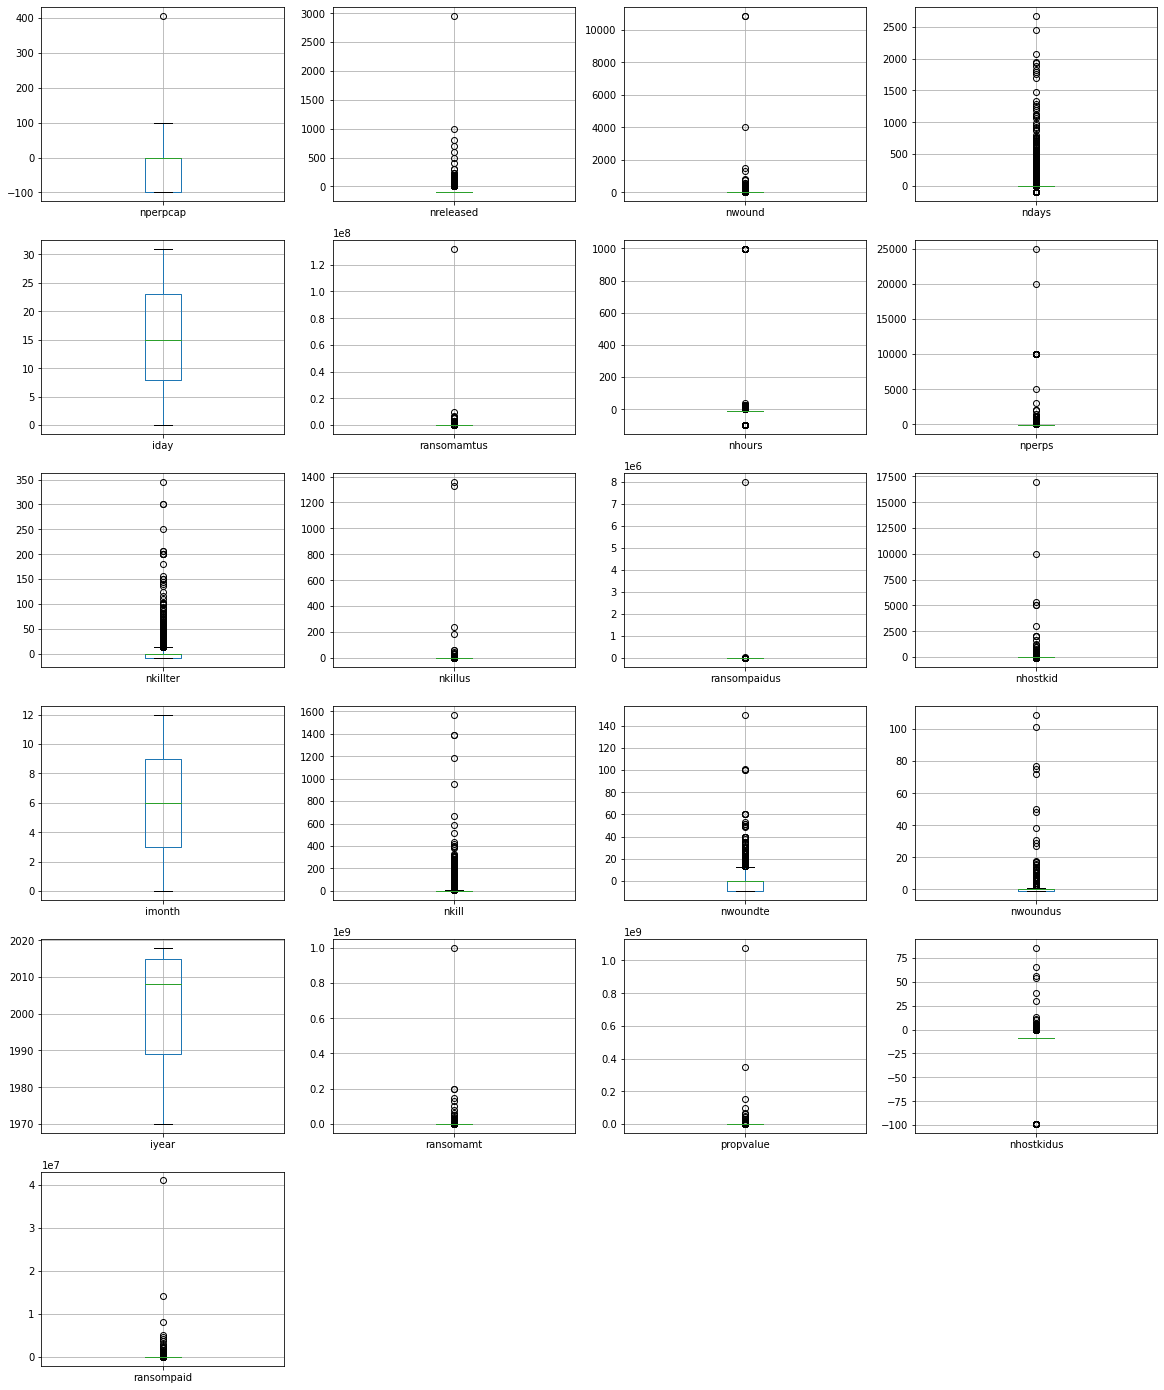

In [268]:
dii = {}
fig = plt.figure(figsize=(20,25))
cols_box = df_temp3_pd.columns

for i in range (len(cols_box)):
  dii[i] =fig.add_subplot(6,4,i+1)
  df_temp3_pd.boxplot(column=cols_box[i])

plt.show()

En los boxplots vemos, por ejemplo, que aquellas variables que expresan un número natural de cualquier suceso a veces toman valores negativos. Por este motivo, establecemos un suelo en 0 para estas variables:

In [269]:
for c in [col for col in df_temp3.columns if col.startswith('n')]:
  df1 = df1.withColumn(c, F.when((F.col(c)<0), 0).otherwise(F.col(c)))

En cuanto al resto, no se percibe nada extraño. Cifras monetarias, como *propvalue* (valor de la propiedad dañada) o *ransompaid* (rescate pagado), si bien presentan algunas observaciones muy por encima del resto, no podemos asegurar que estas sobran de la muestra.
<br>Ilustremos esto consultando un ejemplo donde sospechamos que el rescate pagado es un outlier, pero comprobamos que es verosímil:

In [270]:
df.alias('a').join(df1[df1['ransompaid']>4e7].alias('b'), on='eventid')\
.select('a.gname','a.iyear','a.city','a.attacktype1_txt','a.targsubtype1_txt','a.target1','a.nhostkid','a.ransomamt','a.ransompaid').show(truncate=False)

+----------------------+-----+------------+---------------------------+-------------------------+--------------------------+--------+----------+----------+
|gname                 |iyear|city        |attacktype1_txt            |targsubtype1_txt         |target1                   |nhostkid|ransomamt |ransompaid|
+----------------------+-----+------------+---------------------------+-------------------------+--------------------------+--------+----------+----------+
|Montoneros (Argentina)|1974 |Buenos Aires|Hostage Taking (Kidnapping)|Multinational Corporation|Jorge born, Jr, director *|2.0     |61000000.0|41000000.0|
+----------------------+-----+------------+---------------------------+-------------------------+--------------------------+--------+----------+----------+



In [271]:
df1.write.mode('overwrite').parquet('/databricks/driver/df1_v3.parquet')
shape(df1)

(86473, 135)

In [272]:
df1 = spark.read.format('parquet').load('/databricks/driver/df1_v3.parquet')
shape(df1)

(86473, 135)

## b) Feature Selection

Hasta ahora no hemos excluido ninguna columna. Comenzamos eliminando las variables tipo texto, que ya habíamos almacenado en 'col_txt_drop' en la etapa de estadística descriptiva, porque:
- O tienen asociada una coficiación numérica.
- O no queremos extraer info. de ellas.

In [273]:
print(f'Antes: {shape(df1)}')
df1 = df1.drop(*col_txt_drop)
print(f'Después: {shape(df1)}')

Antes: (86473, 135)
Después: (86473, 83)


Eliminamos variables target excepto gname, que colocamos al final del dataset:

In [274]:
cols_ordenadas = list(set(df1.columns)-set(target_vars))+['gname']
df1=df1.select(cols_ordenadas)
shape(df1)

(86473, 78)

In [275]:
# El id del atentado no es un dato natural del suceso,
# lo ha asignado el propio organismo que ha creado el dataset.
# Como ya no queremos usarlo para hacer cruces, lo descartamos
df2 = df1.drop(*['eventid'])
shape(df2)

(86473, 77)

Llevamos a cabo un Pearson's chi-squared test para ver la independencia de 2 variables categoricas. Las variables que son independientes de la variable objetivo serian las candidatas a ser eliminadas

In [276]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

data=df2.toPandas()
data = data.values
# todas las variables menos la ultima
X = data[:, :-1]
#la ultima variable
y = data[:,-1]
# si infer_schema = "false" entonces los pasamos a string
X = X.astype(str)

oe = OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = LabelEncoder()
le.fit(y)
y = le.transform(y)
# feature selection filtrado
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X, y)
X_fs = fs.transform(X)

Como nos importa más centrarnos en eliminar las que menos score tienen, llevamos a cabo un orden ascentente con el par clave-valor **feature-score**

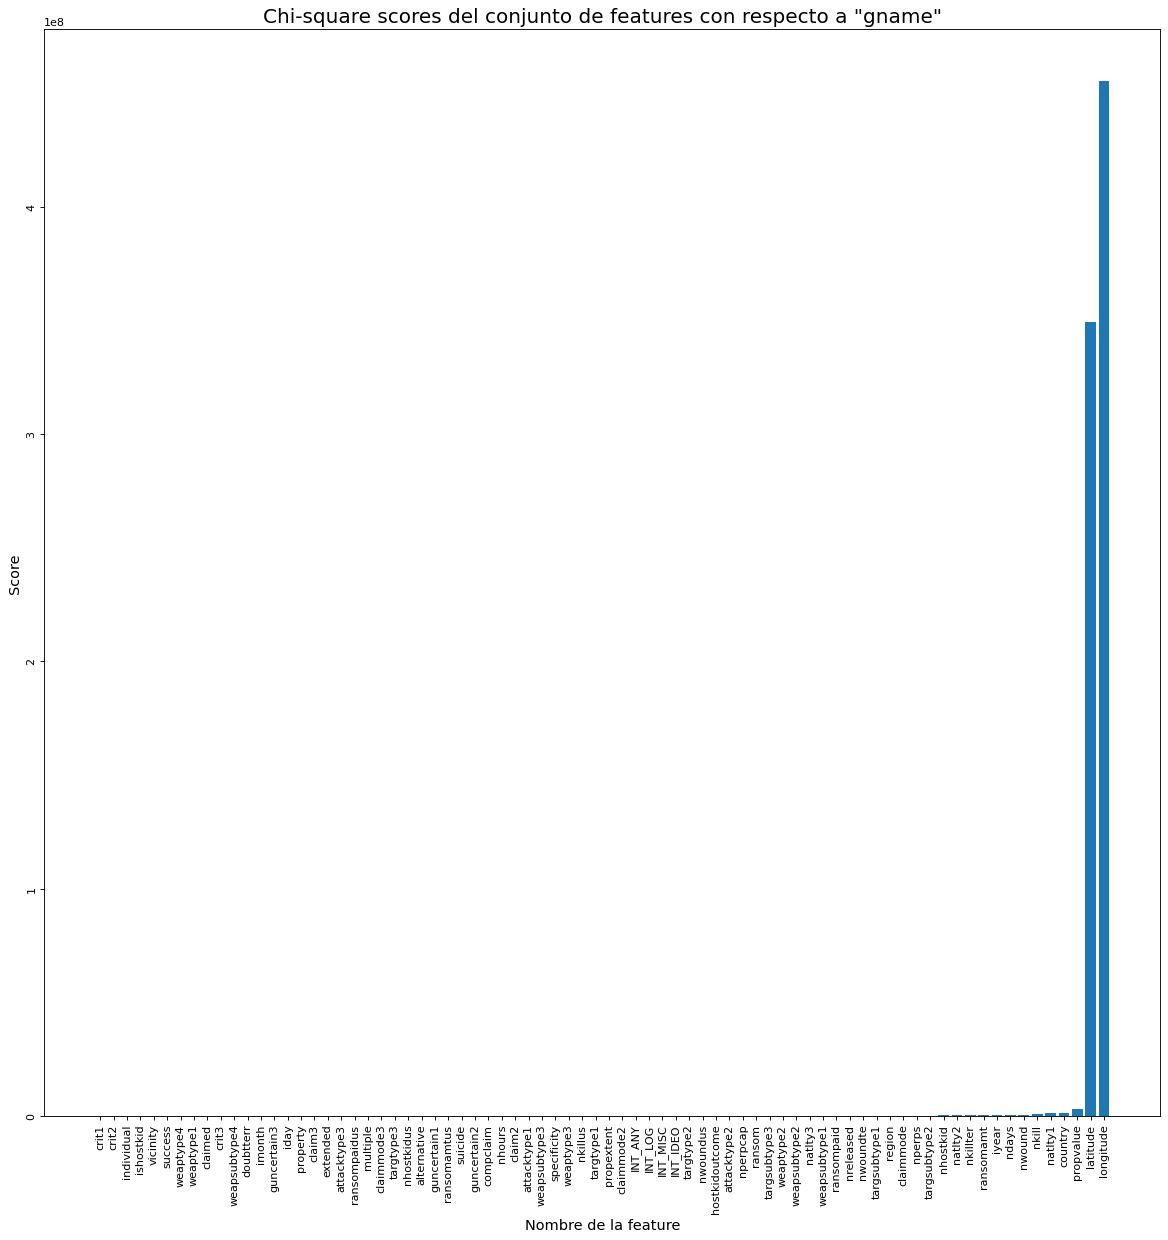

In [277]:
# Creamos diccionario que empareje la feature con su score, de tal modo que nos sea posible
# ordenarlas y visualizarlas, así como ver qué features tienen un score más bajo para su descarte
cols_dicc = {}
features = df2.columns[:-1]
scores = fs.scores_.tolist()
  
for i in range(len(fs.scores_)):
  cols_dicc[features[i]] = scores[i]

cols_dicc = dict(sorted(cols_dicc.items(), key=lambda item: item[1]))
  
# plot the scores
fig, ax = plt.subplots(figsize=(18,18), dpi=80)

ax.set_xlabel('Nombre de la feature', fontsize=13)
ax.set_ylabel('Score', fontsize=13)
ax.set_title('Chi-square scores del conjunto de features con respecto a "gname"', fontsize=18)

ax.set_xticks(range(len(list(cols_dicc.keys()))))
ax.set_xticklabels(list(cols_dicc.keys()))
ax.tick_params(labelrotation=90)
ax = plt.bar([i for i in range(len(fs.scores_))], list(cols_dicc.values()))

plt.show()

Longitud y latitud son, con muchísima diferencia, las variables que más impacto tienen en la variable target, lo que implica que conocer la ubicación de un atentado proporciona casi toda la información de qué grupo terrorista ha sido el responsable. Les siguen propvalue (valor que mide los daños ocasionados), país, nacionalidad de la víctima, nº de muertos, nº de heridos...

## c) Data Transforms

Para simplificar el problema, vamos a seleccionar las 5 más importantes, es decir, hasta el nº de fallecidos y sin contar con el país, ya que asumimos que esta información está detallada en las columnas latitud-longitud y eliminamos el riesgo de incrementar las dimensiones.

In [278]:
last_n_features = 6
final_features = [*cols_dicc.keys()][-last_n_features:] + ['gname']
final_sp = df2[final_features].drop('country')
shape(final_sp)

(86473, 6)

In [279]:
final_sp.show(5,False)

+-----+-------+---------+---------+-----------+-----------------------------+
|nkill|natlty1|propvalue|latitude |longitude  |gname                        |
+-----+-------+---------+---------+-----------+-----------------------------+
|0    |217    |9000     |44.04483 |-123.072606|Student Radicals             |
|0    |217    |-1       |43.113655|-87.900289 |Left-Wing Militants          |
|0    |217    |-1       |40.658455|-73.587219 |Left-Wing Militants          |
|1    |233    |-1       |54.463367|-6.328597  |Irish Republican Army (IRA)  |
|2    |233    |-1       |54.42071 |-6.443767  |Ulster Freedom Fighters (UFF)|
+-----+-------+---------+---------+-----------+-----------------------------+
only showing top 5 rows



### Mean Target Encoding para variables categóricas

Aplicamos Target Encoding para la única variable categórica que permanece en el dataset: *natlty1*, que es la nacionalidad de la(s) víctima(s). Puede ser bueno hacerlo, ya que sus valores pueden explicar la variable objetivo. De este modo, dispondríamos de variables continuas para alimentar los modelos y ayudar en su entrenamiento. Las variables categóricas suelen suponer un problema a la hora de desarrollar modelos.

In [280]:
final_pd = final_sp.toPandas()
y= final_pd.iloc[:,-1:]
X = final_pd.iloc[:,:-1]

In [281]:
# Basado en: https://towardsdatascience.com/target-encoding-for-multi-class-classification-c9a7bcb1a53

def target_encoding(X,y, cat_cols):
    y=y.astype(str)  # forzar target a ser string para hacer one-hot
    enc=category_encoders.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  # Nombres columnas one-hot

    # Forzar las columnas deseadas a ser tipo object
    X[cat_cols] = X[cat_cols].astype('object')
    X_obj=X[cat_cols] # Separar columnas categóricas
    X=X.drop(cat_cols, axis=1)

    for class_ in class_names:
        enc=category_encoders.TargetEncoder()
        enc.fit(X_obj,y_onehot[class_]) #Convertir categóricas
        temp=enc.transform(X_obj)       #Asignar sufijo
        temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
        X=pd.concat([X,temp],axis=1)    #Añadirlas al df resultante
      
    return X

In [282]:
X = target_encoding(X,y, ['natlty1'])
X

,nkill,propvalue,latitude,longitude,natlty1_gname_1,natlty1_gname_2,natlty1_gname_3,natlty1_gname_4,natlty1_gname_5,natlty1_gname_6,natlty1_gname_7,natlty1_gname_8,natlty1_gname_9,natlty1_gname_10,natlty1_gname_11,natlty1_gname_12,natlty1_gname_13,natlty1_gname_14,natlty1_gname_15,natlty1_gname_16,natlty1_gname_17,natlty1_gname_18,natlty1_gname_19,natlty1_gname_20,natlty1_gname_21,natlty1_gname_22,natlty1_gname_23,natlty1_gname_24,natlty1_gname_25,natlty1_gname_26,natlty1_gname_27,natlty1_gname_28,natlty1_gname_29,natlty1_gname_30,natlty1_gname_31,natlty1_gname_32,natlty1_gname_33,natlty1_gname_34,natlty1_gname_35,natlty1_gname_36,...,natlty1_gname_172,natlty1_gname_173,natlty1_gname_174,natlty1_gname_175,natlty1_gname_176,natlty1_gname_177,natlty1_gname_178,natlty1_gname_179,natlty1_gname_180,natlty1_gname_181,natlty1_gname_182,natlty1_gname_183,natlty1_gname_184,natlty1_gname_185,natlty1_gname_186,natlty1_gname_187,natlty1_gname_188,natlty1_gname_189,natlty1_gname_190,natlty1_gname_191,natlty1_gname_192,natlty1_gname_193,natlty1_gname_194,natlty1_gname_195,natlty1_gname_196,natlty1_gname_197,natlty1_gname_198,natlty1_gname_199,natlty1_gname_200,natlty1_gname_201,natlty1_gname_202,natlty1_gname_203,natlty1_gname_204,natlty1_gname_205,natlty1_gname_206,natlty1_gname_207,natlty1_gname_208,natlty1_gname_209,natlty1_gname_210,natlty1_gname_211
0,0,9000,44.044830,-123.072606,0.037736,0.085430,0.004193,0.000000,0.005241,0.000000,0.00000,0.007338,0.013103,0.014675,0.019392,0.043501,0.120021,0.002621,0.003145,0.002621,0.006813,0.005241,0.001048,0.018868,0.000524,0.052411,0.010482,0.014151,0.000000,0.006289,0.002621,0.008910,0.000524,0.020964,0.0,0.0,0.007862,0.0,0.0,0.002096,...,0.001048,0.001572,0.0,0.01782,0.0,0.002096,0.0,0.001048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000524,0.000524,0.0,0.000000,0.0,0.0,0.0,0.0,0.003669,0.001048,0.0,0.001048,0.0,0.0,0.002096,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0,-1,43.113655,-87.900289,0.037736,0.085430,0.004193,0.000000,0.005241,0.000000,0.00000,0.007338,0.013103,0.014675,0.019392,0.043501,0.120021,0.002621,0.003145,0.002621,0.006813,0.005241,0.001048,0.018868,0.000524,0.052411,0.010482,0.014151,0.000000,0.006289,0.002621,0.008910,0.000524,0.020964,0.0,0.0,0.007862,0.0,0.0,0.002096,...,0.001048,0.001572,0.0,0.01782,0.0,0.002096,0.0,0.001048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000524,0.000524,0.0,0.000000,0.0,0.0,0.0,0.0,0.003669,0.001048,0.0,0.001048,0.0,0.0,0.002096,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0,-1,40.658455,-73.587219,0.037736,0.085430,0.004193,0.000000,0.005241,0.000000,0.00000,0.007338,0.013103,0.014675,0.019392,0.043501,0.120021,0.002621,0.003145,0.002621,0.006813,0.005241,0.001048,0.018868,0.000524,0.052411,0.010482,0.014151,0.000000,0.006289,0.002621,0.008910,0.000524,0.020964,0.0,0.0,0.007862,0.0,0.0,0.002096,...,0.001048,0.001572,0.0,0.01782,0.0,0.002096,0.0,0.001048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000524,0.000524,0.0,0.000000,0.0,0.0,0.0,0.0,0.003669,0.001048,0.0,0.001048,0.0,0.0,0.002096,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,1,-1,54.463367,-6.328597,0.000000,0.000000,0.610327,0.074223,0.000000,0.095200,0.12142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028237,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.000403,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.035095,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,2,-1,54.420710,-6.443767,0.000000,0.000000,0.610327,0.074223,0.000000,0.095200,0.12142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028237,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0

En el análisis de outliers, en *propvalue* detectamos valores anómalos. Para lidiar con su presencia, vamos a aplicar signo positivo a toda la columna y vamos a aplicar el logaritmo natural:

In [283]:
min_propvalue = X['propvalue'].min()  # valor mínimo de la columna
X['propvalue'] = np.log1p(X['propvalue']+abs(min_propvalue))

In [284]:
X.describe()

,nkill,propvalue,latitude,longitude,natlty1_gname_1,natlty1_gname_2,natlty1_gname_3,natlty1_gname_4,natlty1_gname_5,natlty1_gname_6,natlty1_gname_7,natlty1_gname_8,natlty1_gname_9,natlty1_gname_10,natlty1_gname_11,natlty1_gname_12,natlty1_gname_13,natlty1_gname_14,natlty1_gname_15,natlty1_gname_16,natlty1_gname_17,natlty1_gname_18,natlty1_gname_19,natlty1_gname_20,natlty1_gname_21,natlty1_gname_22,natlty1_gname_23,natlty1_gname_24,natlty1_gname_25,natlty1_gname_26,natlty1_gname_27,natlty1_gname_28,natlty1_gname_29,natlty1_gname_30,natlty1_gname_31,natlty1_gname_32,natlty1_gname_33,natlty1_gname_34,natlty1_gname_35,natlty1_gname_36,...,natlty1_gname_172,natlty1_gname_173,natlty1_gname_174,natlty1_gname_175,natlty1_gname_176,natlty1_gname_177,natlty1_gname_178,natlty1_gname_179,natlty1_gname_180,natlty1_gname_181,natlty1_gname_182,natlty1_gname_183,natlty1_gname_184,natlty1_gname_185,natlty1_gname_186,natlty1_gname_187,natlty1_gname_188,natlty1_gname_189,natlty1_gname_190,natlty1_gname_191,natlty1_gname_192,natlty1_gname_193,natlty1_gname_194,natlty1_gname_195,natlty1_gname_196,natlty1_gname_197,natlty1_gname_198,natlty1_gname_199,natlty1_gname_200,natlty1_gname_201,natlty1_gname_202,natlty1_gname_203,natlty1_gname_204,natlty1_gname_205,natlty1_gname_206,natlty1_gname_207,natlty1_gname_208,natlty1_gname_209,natlty1_gname_210,natlty1_gname_211
count,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,...,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000,86473.000000
mean,3.075804,4.279876,20.813932,19.813048,0.000856,0.001978,0.030876,0.003008,0.001388,0.003124,0.003875,0.001770,0.000983,0.023380,0.000798,0.000995,0.002684,0.002510,0.001932,0.003181,0.001296,0.001816,0.007381,0.028678,0.000775,0.001388,0.006406,0.000636,0.001435,0.038766,0.003540,0.012991,0.001354,0.052763,0.001435,0.010342,0.004729,0.008283,0.004986,0.000972,...,0.000590,0.001319,0.000636,0.001191,0.001041,0.003181,0.000659,0.000775,0.004813,0.000683,0.000578,0.000891,0.001955,0.002476,0.000648,0.000821,0.000833,0.000914,0.000613,0.001030,0.001122,0.000625,0.001064,0.000683,0.000972,0.067653,0.007242,0.005251,0.000752,0.000856,0.000602,0.004304,0.001284,0.001330,0.002405,0.000578,0.004078,0.000775,0.001793,0.000879
std,14.872482,2.393063,19.144900,62.250437,0.005601,0.012587,0.139620,0.017860,0.008217,0.016408,0.020411,0.007485,0.014050,0.132741,0.003281,0.006396,0.017638,0.034991,0.008647,0.011464,0.026526,0.021623,0.051090,0.103482,0.002580,0.016353,0.022219,0.012294,0.006433,0.182680,0.029101,0.064249,0.017052,0.207909,0.009384,0.074660,0.033553,0.028532,0.065461,0.004657,...,0.004546,0.012691,0.002208,0.008949,0.003541,0.024097,0.005107,0.002755,0.021048,0.001778,0.006414,0.003009,0.006784,0.039352,0.002248,0.010903,0.027426,0.006648,0.008202,0.005584,0.006340,0.008412,0.014331,0.010547,0.010599,0.217423,0.071560,0.046611,0.007689,0.015321,0.003056,0.010926,0.017628,0.034173,0.024304,0.003138,0.043181,0.002689,0.020484,0.011636
min,0.000000,0.000000,-41.472903,-157.818968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [285]:
X.to_pickle('/databricks/driver/df1_v4')
X.shape

(86473, 215)

In [286]:
X = pd.read_pickle('/databricks/driver/df1_v4')
X.shape

(86473, 215)

### Scaling + PCA

Vamos a escalar las variables y aplicar una reducción de dimensionalidad.

In [287]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

Ojo, al usar StandardScaler() estamos asumiendo unimodalidad

In [288]:
pca_pipe = make_pipeline(StandardScaler(), PCA())
# NO supervisado, solo hace falta proporcionarle la X
pca_pipe.fit(X)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

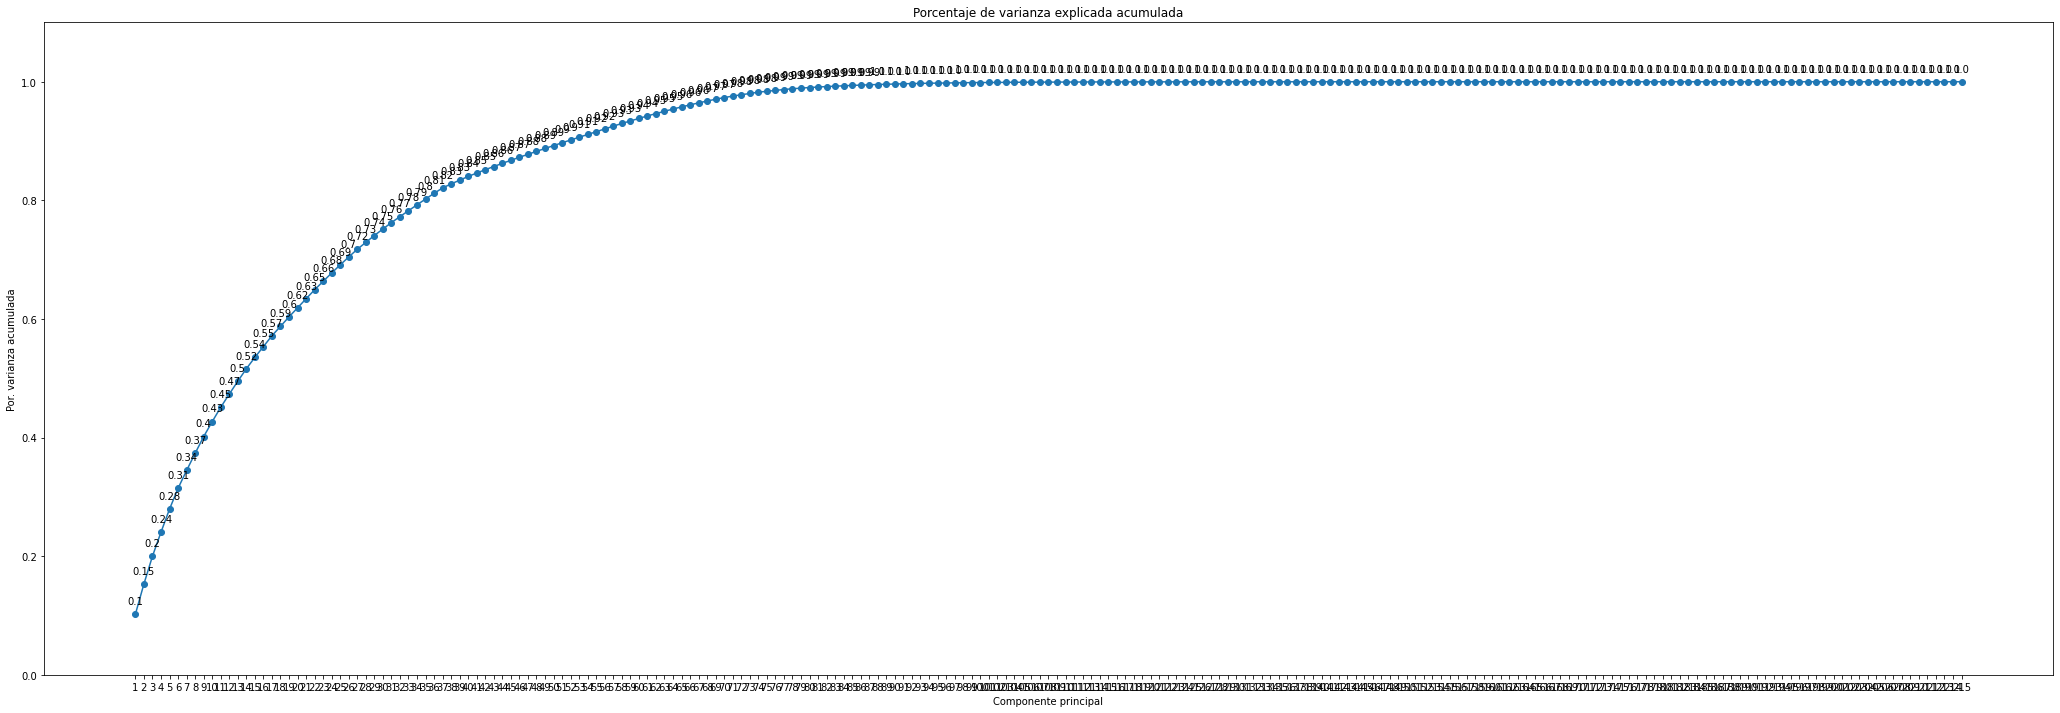

In [289]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(36, 12))
ax.plot(
    np.arange(len(X.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x_, y_ in zip(np.arange(len(X.columns)) + 1, prop_varianza_acum):
    label = round(y_, 2)
    ax.annotate(
        label,
        (x_,y_),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');
plt.show()

In [290]:
n_final_comps = 5
print(f'Las primeras {n_final_comps} componentes principales explican el {round(prop_varianza_acum[n_final_comps]*100,2)}% de la varianza')
pca_pipe_final = make_pipeline(StandardScaler(), PCA(n_components=n_final_comps))
X_scaled_pca = pd.DataFrame(pca_pipe_final.fit_transform(X))

Las primeras 5 componentes principales explican el 31.45% de la varianza


Vamos a seleccionar tan solo 5 componentes principales, con el fin de poder entrenar modelos de manera ágil en el siguiente apartado. Lo ideal sería obtener el número óptimo de componentes mediante el método "del codo". Se hallaría ese punto donde, al seguir aumentando la dimensionalidad, no se obtendría una ganancia significativa de varianza.

In [291]:
prop_varianza_acum[75]*100

98.54587602432477

Vemos como, por ejemplo, 75 sería un buen número de componentes, ya que antes de llevar a cabo el PCA había 228 columnas. Con las 75 primeras PCs, se recogería cerca del 99% de la varianza.

In [292]:
final_pd = pd.concat([X_scaled_pca, y], axis = 1)
final_pd.iloc[np.r_[0:2, -2:0]]

,0,1,2,3,4,gname
0,-2.604381,0.592984,-2.758234,-0.416283,17.722289,Student Radicals
1,-2.543820,0.425266,-2.767016,-0.439353,17.627932,Left-Wing Militants
86471,-1.310216,-0.330525,-0.992422,-1.229349,-0.440277,Islamic State of Iraq and the Levant (ISIL)
86472,-1.128644,-1.097381,-0.099215,-0.559506,-0.202855,Taliban


# 4. Evaluate Algorithms

El problema de clasificación multiclase final, tras la limpieza de los datos, tiene 224 clases únicas a predecir.

In [293]:
print(f'La variable target tiene {len(y.gname.unique())} clases')

La variable target tiene 211 clases


## a) Split-out validation dataset

**Método clásico**:

In [294]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_pd, test_size=0.2)

y_train_txt = train.iloc[:,-1:]
X_train = train.iloc[:,:-1]

y_test_txt = test.iloc[:,-1:]
X_test = test.iloc[:,:-1]

label_encoder = LabelEncoder()  # OrdinalEncoder
y_train = label_encoder.fit_transform(y_train_txt.values.ravel())
y_test = label_encoder.fit_transform(y_test_txt.values.ravel())

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69178, 5), (17295, 5), (69178,), (17295,))

Mejor emplear **Stratified sampling**:

Dado el presente problema de clasificación multilabel con un nº elevado de clases, la idea que subyace a este método de estratificación es poder balancear la aparición de todas las clases en los splits de train y test. De este modo prevenimos, por ejemplo, evaluar una serie de grupos terroristas que no aparecían en el y_train y disminuir el error.

In [295]:
y = pd.DataFrame(label_encoder.fit_transform(y.values.ravel()), columns=['grupo'])

In [296]:
from skmultilearn.model_selection import IterativeStratification

# Basado en: https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat
stratifier = IterativeStratification(n_splits=2, order=2, sample_distribution_per_fold=[0.2, 0.8])
train_indexes, test_indexes = next(stratifier.split(X_scaled_pca, y))

X_train, y_train = X_scaled_pca.loc[train_indexes], y.loc[train_indexes]
X_test, y_test = X_scaled_pca.loc[test_indexes], y.loc[test_indexes]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69178, 5), (17295, 5), (69178, 1), (17295, 1))

La distribución en # de registros es la misma que con el método clásico, pero ahora las clases están mejor repartidas.

## b) Select Algorithms & c) Evaluation metric

In [297]:
import time

In [298]:
# Redimensión
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

## Regresión Logística

In [299]:
from sklearn.linear_model import LogisticRegression

t = time.time()
model_LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=100)

# fit the model
model_LR.fit(X_train, y_train)

elapsed = time.time() - t
print(f'Tiempo entrenamiento: {elapsed} s.')

# Calcula accuracy modelo
acc_LR = round(model_LR.score(X_test, y_test), 5)
print("Regresión Acc: {0}".format(acc_LR))

Tiempo entrenamiento: 103.40036010742188 s.
Regresión Acc: 0.46696


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## Árbol de Decisión

In [300]:
from sklearn import tree

In [301]:
# "baseline" rápido con profundidad máxima 3 y tamaño de hoja 10000,
t = time.time()
model_DT = tree.DecisionTreeClassifier(max_depth=3, max_leaf_nodes=1000, random_state=0)
model_DT.fit(X_train, y_train)
elapsed = time.time() - t
print(f'Tiempo entrenamiento: {elapsed} s.')

# Calcula accuracy modelo
acc_DT = round(model_DT.score(X_test, y_test), 5)
print("Árbol Acc: {0}".format(acc_DT))

Tiempo entrenamiento: 0.41166257858276367 s.
Árbol Acc: 0.15432


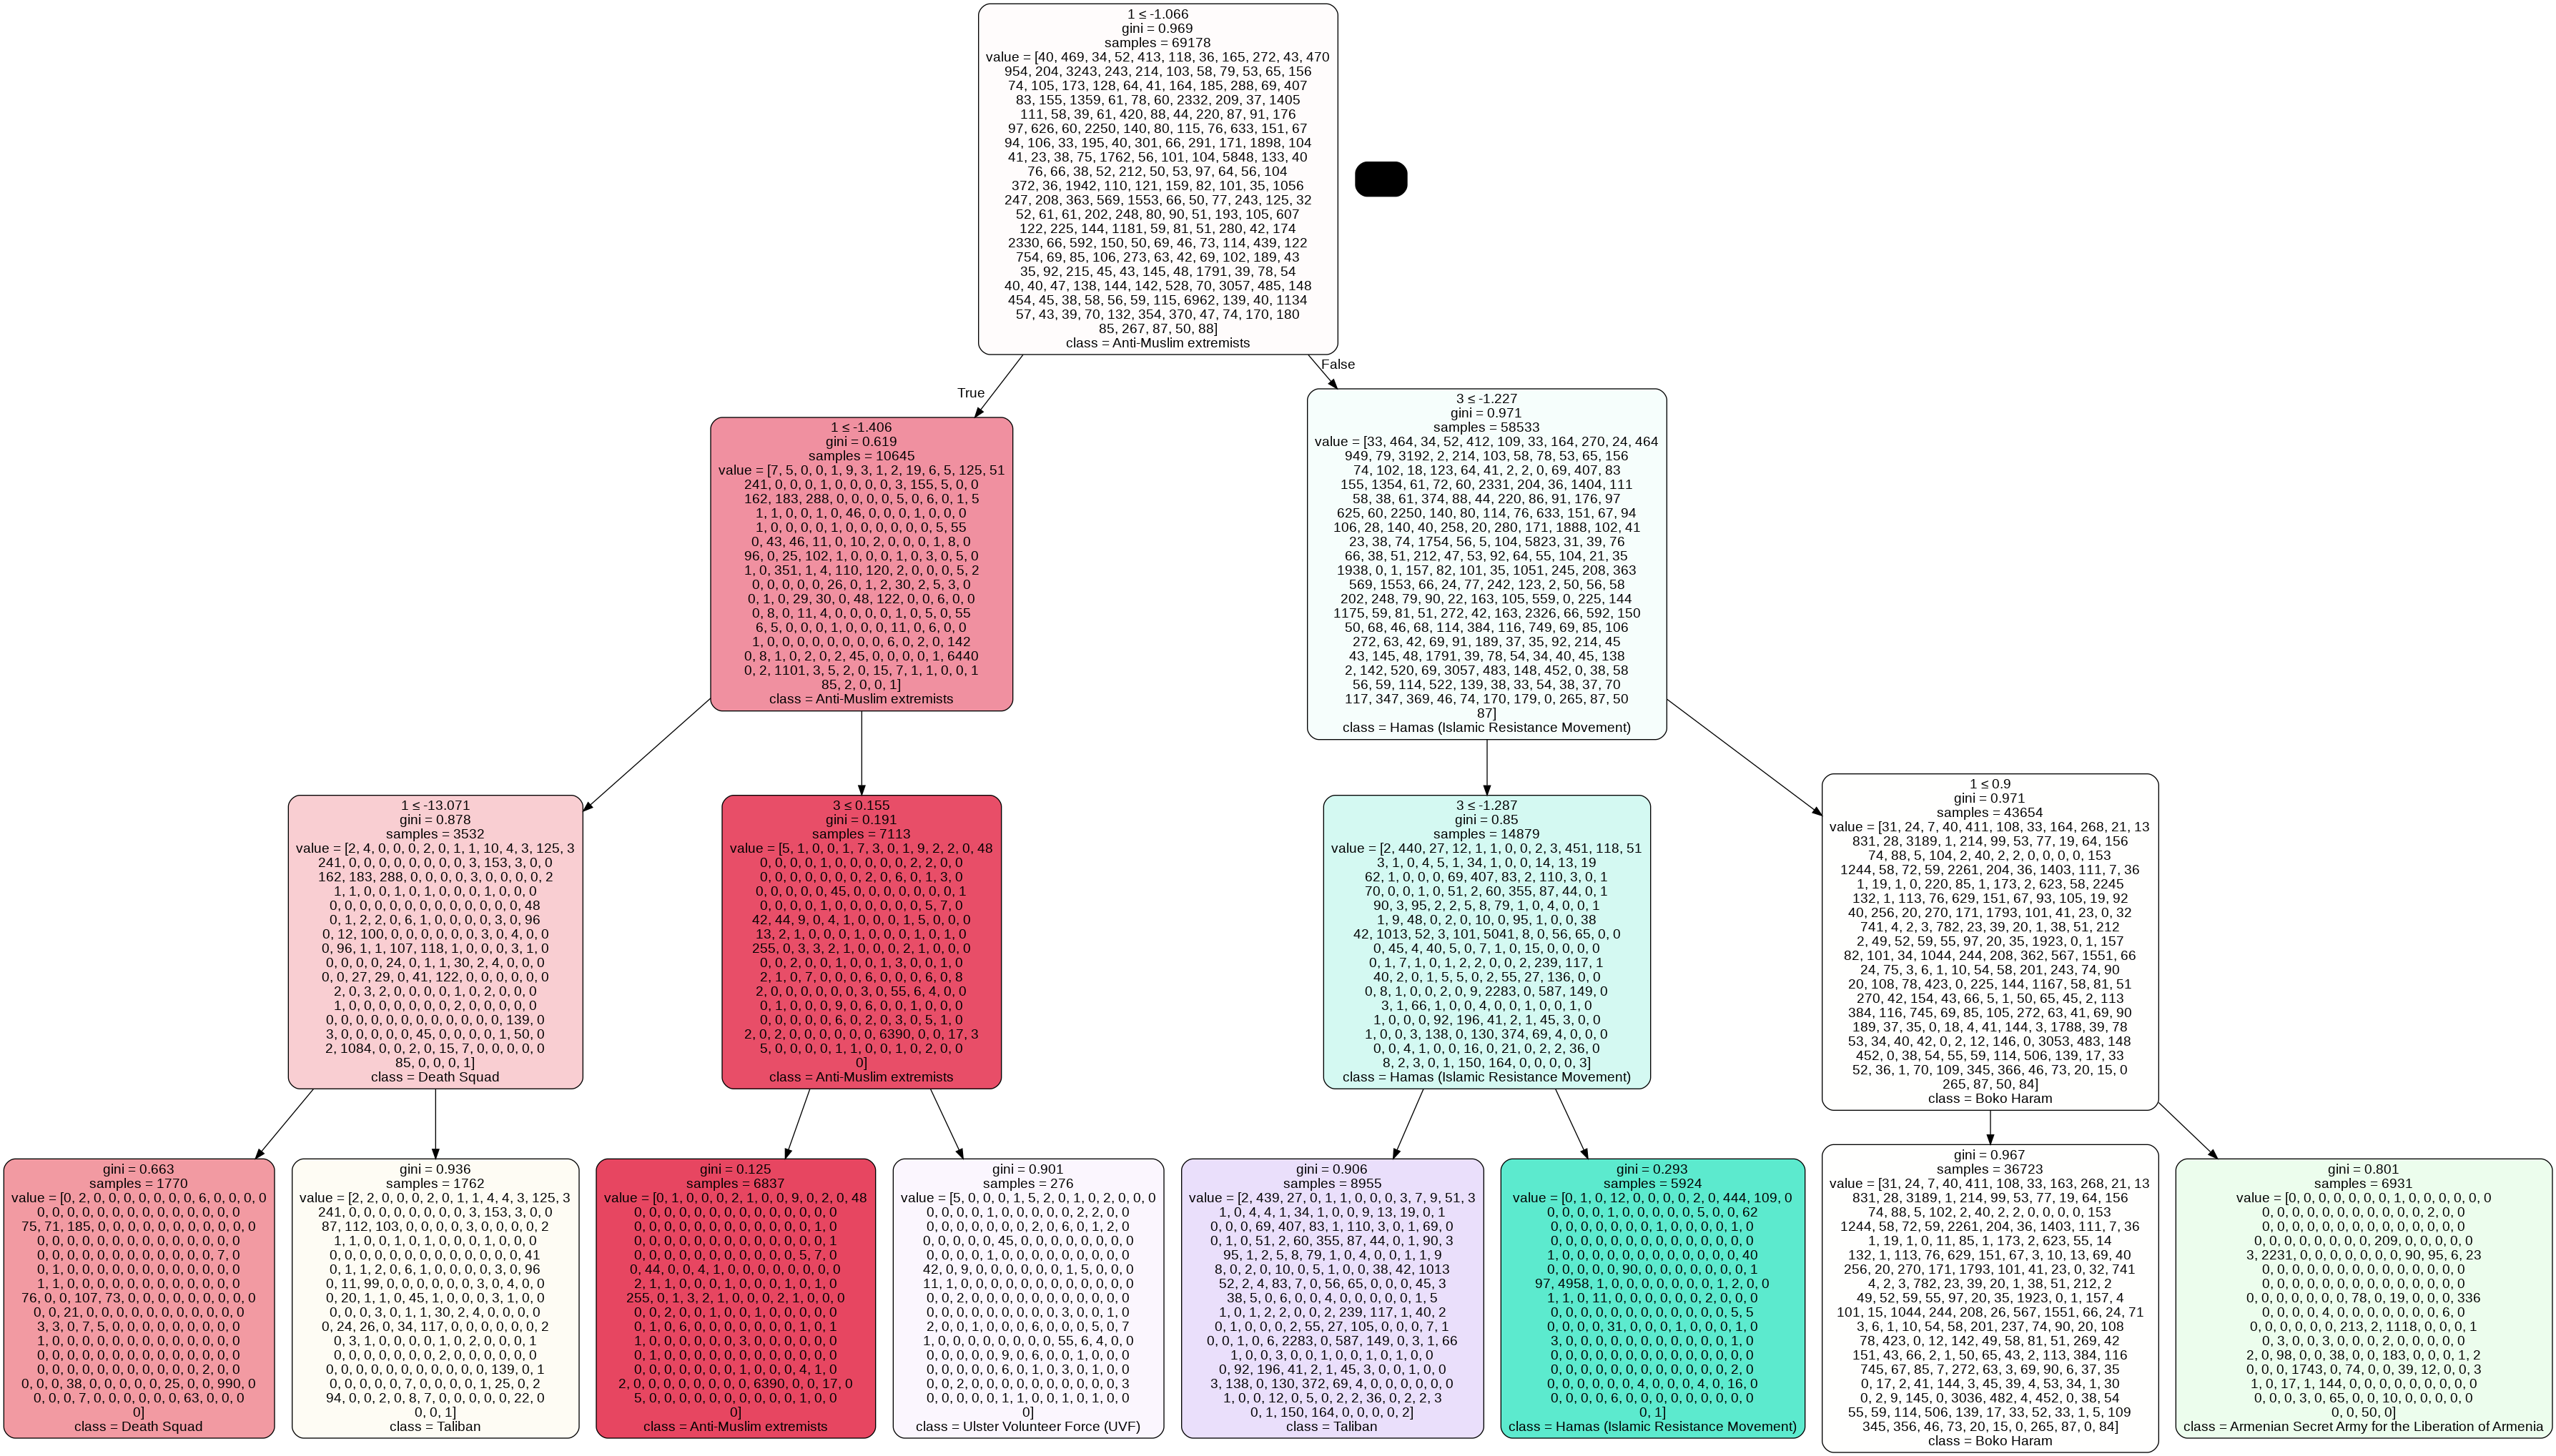

In [302]:
# Podemos visualizarlo ya que no tiene gran tamaño
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(model_DT, out_file=dot_data, filled=True, rounded=True,
                special_characters=True,
                feature_names = X_train.columns.tolist(),
                class_names = y_train_txt.values.ravel())

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

In [303]:
# solo especificamos semilla, pero no limitamos profundidad ni tam. de la hoja
t = time.time()
model_DT = tree.DecisionTreeClassifier(random_state=0)
model_DT.fit(X_train, y_train)
elapsed = time.time() - t
print(f'Tiempo entrenamiento: {elapsed} s.')

# Calcula accuracy modelo
acc_DT = round(model_DT.score(X_test, y_test), 5)
print("Árbol Acc: {0}".format(acc_DT))

Tiempo entrenamiento: 2.236818790435791 s.
Árbol Acc: 0.67846


**Buen accuracy para lo rápido que ha sido entrenarlo**

## Random Forest

In [304]:
from sklearn.ensemble import RandomForestClassifier

In [305]:
t = time.time()
model_RF = RandomForestClassifier(n_estimators=50, random_state=0)
model_RF.fit(X_train, y_train)
elapsed = time.time() - t
print(f'Tiempo entrenamiento: {elapsed} s.')

# Calcula accuracy modelo
acc_RF = round(model_RF.score(X_test, y_test), 5)
print("Random Forest Acc: {0}".format(acc_RF))

Tiempo entrenamiento: 29.71016263961792 s.
Random Forest Acc: 0.69962


## **Random Forest solo con latitud y longitud (sin escalar ni PCA)**

In [306]:
this_X = X[['latitude','longitude']]

train_indexes, test_indexes = next(stratifier.split(this_X, y))

X_train_, y_train_ = this_X.loc[train_indexes], y.loc[train_indexes]
X_test_, y_test_ = this_X.loc[test_indexes], y.loc[test_indexes]

X_train_.shape, X_test_.shape, y_train_.shape, y_test_.shape

((69178, 2), (17295, 2), (69178, 1), (17295, 1))

In [307]:
t = time.time()
model_RF_latlong = RandomForestClassifier(n_estimators=50, random_state=0)
model_RF_latlong.fit(X_train_, y_train_.values.ravel())
elapsed = time.time() - t
print(f'Tiempo entrenamiento: {elapsed} s.')

# Calcula accuracy modelo
acc_RF_latlong = round(model_RF_latlong.score(X_test_, y_test_.values.ravel()), 5)
print("Random Forest Acc: {0}".format(acc_RF_latlong))

Tiempo entrenamiento: 14.521683931350708 s.
Random Forest Acc: 0.69043


A pesar de emplear solo latitud y longitud (sin incluir más features+mean encoding+Scaling+PCA...), la performance no difiere mucho.

## Conclusiones
Teniendo en cuenta que son 224 clases, que se han seleccionado solo 5 componentes del PCA y que se ha empleado poco esmero en el ajuste de hiperparámetros de los modelos, no están nada mal las performances logradas. Como línea de mejora, propongo emplear un GridSearch con el que poder comprobar qué técnicas de preprocesamiento en combinación con los diversos modelo-hiperparámetro obtiene mayor performance, así como valoraría utilizar otras métricas de evaluación.

# 5. Finalize model

### a) Predictions on validation dataset: predice con el dataset de entrenamiento

In [308]:
predictions = model_RF.predict(X_test)
predictions

array([105,  80,  37, ..., 151, 151, 184])

### b) Create model on entire training dataset: ahora entrena ya con todo el dataset como si fueras a ponerlo en producción

In [309]:
model_RF2 = RandomForestClassifier(n_estimators=10, random_state=0)
model_RF2.fit(X_scaled_pca, y.values.ravel())

predictions = model_RF2.predict(X_scaled_pca)
predictions

array([188, 105, 105, ...,  84,  84, 191])

### c) Save model for later use

In [310]:
from pickle import dump
from pickle import load

In [311]:
filename = 'model_RF.sav'
dump(model_RF2, open(filename, 'wb'))

In [312]:
# descomentar para cargar el modelo
loaded_model = load(open(filename, 'rb'))
predictions2 = loaded_model.predict(X_scaled_pca)
predictions2

array([188, 105, 105, ...,  84,  84, 191])